# Biological Imaging Analysis with Python
#### 1. Algorithmic cell counting
#### 2. Fluorescence quantification
#### 3. Automatic figure regeneration


##### Some of the code is pre-written, and you will simply execute it. In other cases, you will be prompted to write some code lines to advance towards this goal. **There are going to be 8 such prompts,** plus some bonus challenges if you want to keep going.

## Imports of packages we will need for this notebook. 
#### All of these are standard and most that we have talked about. Other packages will be introduced as needed.

In [3]:
import numpy as np
import seaborn as sns
import os,sys,glob
import matplotlib.pyplot as plt

one packages we haven't talked about is this custom "package" ```utils``` i have added to this repository. it only has one function for now, which we will use much later, but it has an example for how to import a local package of your making, for reusing code across notebooks. note that this code is in viewable in the sidebar <--- to the left, in the ```utils``` folder

In [18]:
import utils

### 1. Algorithmic cell counting. 
#### The goal of this section is to develop some code that will automatically count things in an image. Generally speaking, this type of automated image analysis is quite useful - counting how many cells are in a culture dish, or how many nuclei have fragmented (apoptosis), or how many PSD95 (or whatever!) puncta there are in an image. 
#### First, we'll load an image of some cells in culture. 
We'll use a loading function from the ```matplotlib``` package:

In [4]:
image = plt.imread("./res/cell-counting_image.png")

So, we've loaded a pre-provided , we think, no error. 
<br>**First question of this exercise:<br>Q1. What type of data is ```image```? write some code that will give the answer in the cell below:**

But what does this image of cells look like, actually? we want to take a look to make sure everything looks as we would expect

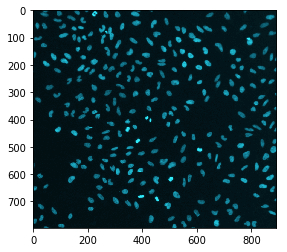

In [5]:
plt.imshow(image)

A color image! Great. But what is the information in each color? How does ```plt.imshow(image)``` know to make this a color image? Let's check the shape of ```image```

In [ ]:
np.shape(image)

Let's see what is in each color:

In [ ]:
for color in range(np.shape(image)[2]):  # go through each color image
    plt.figure()            # make a new figure
    plt.imshow(image[:,:,color],cmap=plt.cm.Greys) # show that image, in black and white

There's not much information in the color, so let's combine them. We'll do it by 

In [ ]:
image_bw = np.sum(image,axis=2)

Let's take a look at what this summed image looks like. 
<br>**Q2: plot  ```image_bw```**

To keep going towards our goal, we're going to use some very useful image analysius packages: ```scikit-image```, or ```skimage```, and one part of ```scipy```, ```scipy.ndimage```. These are packages that were developed primarily by computer scientists for machine vision purposes, but we can take advantage of them for our task here.

In [8]:
from skimage.filters import threshold_otsu
from scipy import ndimage

Let's first get rid of some noise

In [9]:
guassian_sigma = 2.5

In [ ]:
plt.imshow(ndimage.gaussian_filter(image_bw,guassian_sigma))

Nex,t we try label every pixels has having a cell there or not, so binary yes or no:

In [ ]:
thresh = threshold_otsu(ndimage.gaussian_filter(image_bw,guassian_sigma))
# thresh = ndimage.gaussian_filter(thresh,9)
binary = ndimage.gaussian_filter(image_bw,guassian_sigma) > thresh

In [ ]:
plt.imshow(binary)

In [ ]:
filled_in = ndimage.binary_fill_holes(binary)

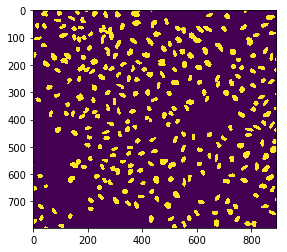

In [185]:
plt.imshow(filled_in)

Finally, we count how many things there are in this image

In [186]:
labeled_cells, b = ndimage.label(filled_in)

**Q3: How many cells are there in the image? Assign the number to the variable ```cell_count```** _Hint: google ```ndimage.label```_

### 2. Comparing fluourescence images
#### The goal of this section will be to quantify the overlap between fluoresence images. These raw data have been graciously provided by Helena Barr from the Hughes Lab. Much appreciated! These are images of microglia. 
Again we'll use the ```skimage``` pacakge, in this case to load the images. We will load the images into a ```numpy <ndarray>```

In [10]:
from skimage import io

In [11]:
image_stack = io.imread('./res/Microglia_1d.tif')

As you can tell from the variable name, this one file is an image stack.

<br>**Q4. How many images are there in this image stack? Another way to ask this: what is the shape of ```image_stack```? write some code that will give the answer in the cell(s) below. Assign variables ```num_images``` , ```width```, ```length``` with your answer** If you need more cells, go ahead and add them!

Let's take a look at the images:

In [ ]:
for image_number in range(num_images):
    plt.figure()
    plt.imshow(image_stack[image_number,:,:])

These images look largely the same, but slightly different (they are a time-lapse capture). 
<br>Let's ask: over these ```num_images```, does the cell increase or decrease fluorescence? How much?

Let's wrap the preprocessing we did above into a function, which takes in an image and returns that image, after it has been thresholded and filled in. 

In [12]:
def preprocess_image(image,gaussian_sigma=.75,threshold=130):
    binary = ndimage.gaussian_filter(image,gaussian_sigma) > threshold
    filled_in = ndimage.binary_fill_holes(binary)
    return filled_in

We can now go over the stack images, which is going through time, and see how this cell is changing

In [ ]:
for ind in range(num_images-1):
    diff_between_images = preprocess_image(image_stack[ind+1,:,:]) ^ preprocess_image(image_stack[ind,:,:])
    plt.figure()
    plt.imshow(diff_between_images,cmap=plt.cm.Greys)

Now, instead of plottting, let's measure the number of pixels that are different


In [16]:
pixel_differences = [] # make a list
for ind in range(num_images-1):
    diff_between_images = preprocess_image(image_stack[ind+1,:,:]) ^ preprocess_image(image_stack[ind,:,:])
    number_of_different_pixels = np.sum(diff_between_images)
    pixel_differences.extend([number_of_different_pixels])
pixel_differences = np.array(pixel_differences)

Great, we have the number of pixels that has changes. But the meaning of this depends on how many pixels there are in the image. Let's convert this to the percentage of pixels that have changed. 
<br>**Q5: How many pixels are there in each image? Assign this to the variable ```total_number_of_pixels```**

<br>**Q6: Remake the above plot, but with percentage of different pixels instead of total number**

Text(0.5, 0, 'time (arbitrary unit)')

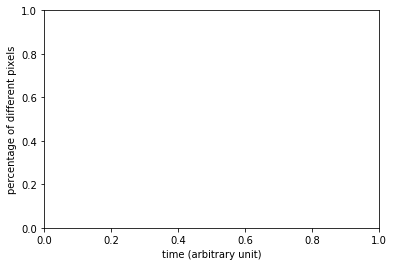

In [21]:
plt.ylabel('percentage of different pixels')
plt.xlabel('time (arbitrary unit)')

Let's wrap this up by making a big function that makes a bar chart, which shows the mean and standard deviation of the percentage change over time. I'll write this one:

In [45]:
def get_percent_change_between_image(stacks):
    means = np.zeros(len(stacks))
    stds = np.zeros(len(stacks))
    for i,image_stack in enumerate(stacks):
        pixel_differences = [] # make a list
        for ind in range(num_images-1):
            diff_between_images = preprocess_image(image_stack[ind+1,:,:]) ^ preprocess_image(image_stack[ind,:,:])
            number_of_different_pixels = np.sum(diff_between_images)
            pixel_differences.extend([number_of_different_pixels])
        pixel_differences = np.array(pixel_differences) / total_number_of_pixels

        means[i]=np.mean(pixel_differences)
        stds[i] =np.std(pixel_differences)

    return means, stds

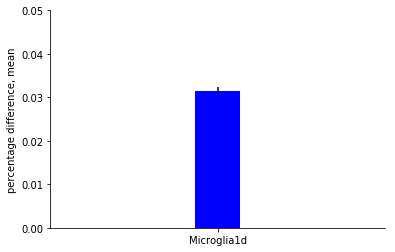

In [46]:
mean, std = get_percent_change_between_image([image_stack])

plt.bar(1,mean,yerr=std,color='b')
plt.xlim(-2,4)
plt.ylim(0,0.05)
plt.ylabel('percentage difference, mean')
plt.xticks([1],['Microglia1d'])

utils.cleanAxes(plt.gca(),leftLabels=True,bottomLabels=True)

### 3. Automating Figure production

One very convenient application of scripting languages, whether it MATLAB or python or whatever, is the ability to automate your fixed analyses to produce updated plots once you have more data. This could be done with _any_ type of data, but in this final example we will do it with the Hughes Lab microglia data.
<br><br>First, let's make a plot of some analysis of one set of data. In this case, we will use ```microglia_1d.tif```. But instead of directly writing a path to this data, we'll search a folder for all data that starts with ```"Microglia"```

In [47]:
path_to_data_folder = './res'

_Note_: in this case for our exercise, we are using a local folder in the JupyterHub folder. But it could be any folder. Your could point it to Desktop, or Documents, or "C:/folder_where_keep_my_data:", etc.
<br><br>
Now we'll get a list of all of the files in this folder that are called ```microglia_1```+any letter or character+```.tif```. we use use two python standard library pacakages: ```glob```, which is great for searching folders in flexible ways, and ```os```, which is critical for cross-platform compatibility when browsing file systems

In [48]:
microglia_image_paths = glob.glob(os.path.join(path_to_data_folder,'Microglia_1*.tif'))
print(microglia_image_paths)

['./res/Microglia_1d.tif']


so, we can get this image by loading it the same way we did before:

In [49]:
image_stack_1 = io.imread(microglia_image_paths[0])

Now, let's imagine you collect some more data. You put it in the same folder, and you call it ```Microglia_2d.tif```

**Q7: Use ```glob``` to find all .tif files that start with "Microglia" in the same folder. Call this ```image_paths```**

In [51]:
image_paths = glob.glob(os.path.join(path_to_data_folder,'Microglia_*'))

Now we get all of these tif images, and 

In [52]:
images_all = [io.imread(path) for path in image_paths]

In [53]:
means, stds = get_percent_change_between_image(images_all)

In [57]:
image_paths

['./res/Microglia_2d.tif', './res/Microglia_1d.tif']

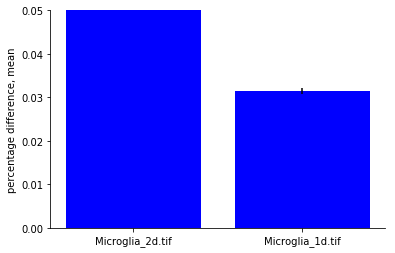

In [59]:
plt.bar(range(len(means)),means,yerr=stds,color='b')
# plt.xlim(-2,4)
plt.ylim(0,0.05)
plt.ylabel('percentage difference, mean')

utils.cleanAxes(plt.gca(),leftLabels=True,bottomLabels=True)

**Q8: Make the plot again, but make the bars different colors and mak